In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mapsplotlib import mapsplot as mplt
import folium
from gmplot import gmplot
import branca
import seaborn as sns
# import plotly.plotly as py
# import plotly.graph_objs as go

%matplotlib inline
# import mpld3
# mpld3.enable_notebook()

# load data

In [2]:
sales_granular = pd.read_csv('data/sales_granular.csv')

surrounding = pd.read_json('data/Surroundings.json')

In [3]:
print("sales_granular.csv")
print("Number of shops", len(sales_granular))
assert sales_granular.columns[0] == 'store_code'
dates = sales_granular.columns[1:]
print("Data from", dates[0], "to", dates[-1])
print()

print("surrounding.json")
print(surrounding.keys())
print("Number of shops", len(surrounding))

sales_granular.csv
Number of shops 906
Data from 8/3/15 9:00 to 6/25/17 22:00

surrounding.json
Index(['store_code', 'surroundings'], dtype='object')
Number of shops 546


In [4]:
# merge to focus only on the stores where we have both sales and info on surroundings
store = pd.merge(sales_granular, surrounding, how='inner', on='store_code')
len(store)

546

# lets define our target variable

In [5]:
# performance will be define as the total of sales
# calculate total for each POS
# on all data, per day of week, monthly, annualy
# having the target not only on the all period can help to detect different features
# notes: day of year too sparse, day of month too

index_time = store[dates].T  # transpose to have timestamp on index -> easier
dt = pd.to_datetime(index_time.index)

total = index_time.sum().rename("total")
total_dayofweek = index_time.groupby(dt.dayofweek).sum()
total_month = index_time.groupby(dt.month).sum()
total_year = index_time.groupby(dt.year).sum()
total_hour = index_time.groupby(dt.hour).sum()

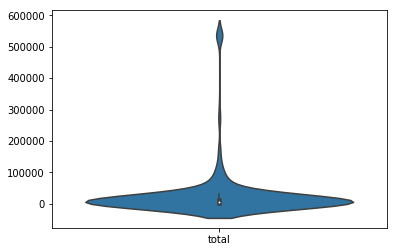

In [6]:
# total.plot()
# total.head()
ax = sns.violinplot(data=pd.DataFrame(total))

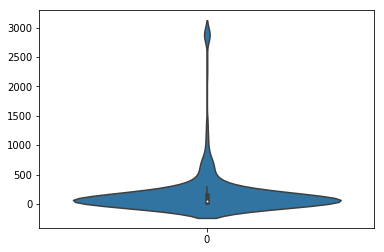

In [7]:
# index_time.count().plot()
ax = sns.violinplot(data=index_time.count())

the correlation between total of sells and number of day worked is pretty high

ideally the position of a POS should be decided by the interest of the area

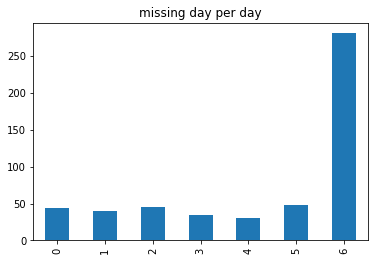

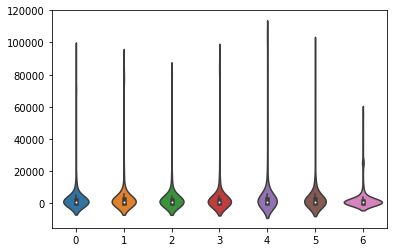

In [8]:
total_dayofweek.T.isnull().sum().plot.bar(title="missing day per day")
plt.show()
# total_dayofweek.plot(legend=False)
# total_dayofweek
ax = sns.violinplot(data=pd.DataFrame(total_dayofweek).T)

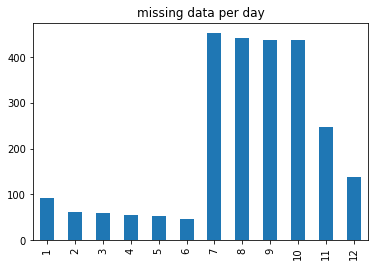

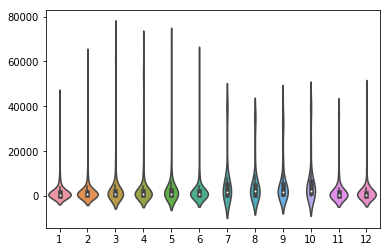

In [9]:
total_month.T.isnull().sum().plot.bar(title="missing data per day")
plt.show()
# total_month.plot(legend=False)
ax = sns.violinplot(data=total_month.T)

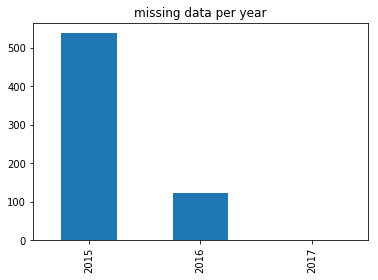

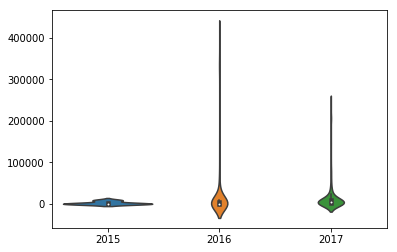

In [10]:
total_year.T.isnull().sum().plot.bar(title="missing data per year")
plt.show()
# total_year.plot(legend=False)
ax = sns.violinplot(data=total_year.T)

In [95]:
total_year

0       1         2        3        4        5         6        7    \
2015      NaN     NaN       NaN      NaN      NaN      NaN       NaN      NaN   
2016  20790.0   330.0  154740.0      NaN      NaN  49740.0   68100.0   2820.0   
2017  12990.0  3570.0  115470.0  33810.0  18000.0  21060.0  103950.0  17460.0   

          8        9     ...         536    537     538      539    540  \
2015      NaN      NaN   ...         NaN    NaN     NaN      NaN    NaN   
2016  65250.0   1800.0   ...      1530.0    NaN   690.0      NaN   30.0   
2017  37260.0  28590.0   ...     13980.0  330.0  1140.0  14160.0  480.0   

          541     542     543    544      545  
2015      NaN     NaN     NaN    NaN      NaN  
2016      NaN  1200.0   240.0    NaN      NaN  
2017  34740.0  6180.0  1890.0  120.0  13380.0  

[3 rows x 546 columns]

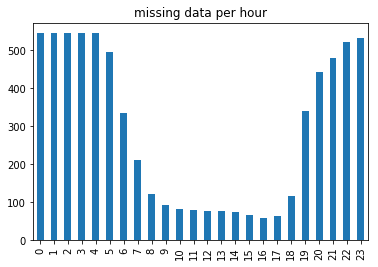

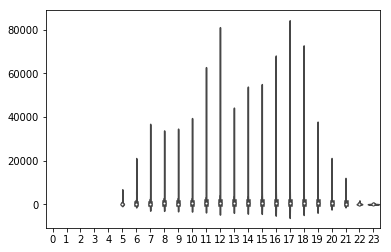

In [11]:
total_hour.T.isnull().sum().plot.bar(title="missing data per hour")
plt.show()
# total_hour.plot(legend=False)
ax = sns.violinplot(data=total_hour.T)

the thing is that it seems that some place opened after others as some years have no income

some are also more likely to be close during summer vacation or sundays

to not have this biasing our result we can normalise per the days were something have been written

aka no nan

we will see later how that affect our analysis

the thing is that maybe some area cannot work on sundays but others can? that can modify the analysis

but i dont know enough about suisse custom and law to go further on this



In [12]:
total_norm = total / index_time.count()
total_dayofweek_norm = total_dayofweek / index_time.groupby(dt.dayofweek).count()
total_month_norm = total_month / index_time.groupby(dt.month).count()
total_year_norm = total_year / index_time.groupby(dt.year).count()
total_hour_norm = total_hour / index_time.groupby(dt.hour).count()

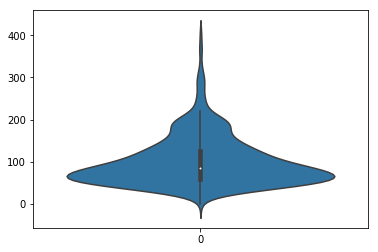

In [13]:
# total_norm.plot()
ax = sns.violinplot(data=total_norm)

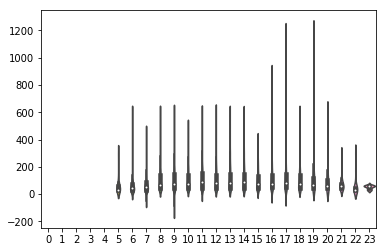

In [14]:
# total_hour_norm.plot(legend=False)
ax = sns.violinplot(data=total_hour_norm.T)

this look more balanced, hence the number of days doesnt matter

we can focus now on area related features

note: we need to keep in mind that this consider that the number of days worked doesnt matter

In [15]:
target_dict = {'total': total.T,
               'total_dayofweek': total_dayofweek.T,
               'total_month': total_month.T,
               'total_year': total_year.T,
               'total_norm': total_norm.T,
               'total_dayofweek_norm': total_dayofweek_norm.T,
               'total_month_norm': total_month_norm.T,
               'total_year_norm': total_year_norm.T}

In [16]:
targets = pd.concat(target_dict, 1)
targets.head()
len(targets)

546

# lets dig inside the data about the surrounding

In [17]:
surrounding.head()

store_code                                       surroundings
0       10055  {'subway_station': [], 'department_store': [],...
1       10077  {'subway_station': [], 'department_store': [],...
2       10079  {'subway_station': [], 'department_store': [{'...
3       10086  {'subway_station': [], 'department_store': [],...
4       10111  {'subway_station': [], 'department_store': [],...

In [18]:
# lets check a bit more what is in the surroundings column
surr = store.surroundings.apply(pd.Series)
surr.head()

accounting airport amusement_park  \
0  [{'name': 'Fiduciaire Exacte & Gestion Comptab...      []             []   
1                                                 []      []             []   
2  [{'website': 'http://www.vd.ch/autorites/depar...      []             []   
3                                                 []      []             []   
4                                                 []      []             []   

  aquarium                                        art_gallery  \
0       []  [{'website': 'http://www.onegeeinfog.com/', 'n...   
1       []                                                 []   
2       []                                                 []   
3       []                                                 []   
4       []                                                 []   

                                                 atm  \
0  [{'website': 'https://www.ubs.com/ch/fr.html',...   
1                                                 []   
2  [{'name': 'PickPost-Stelle', 'opening_hours': ...   
3                                                 []   
4                                                 []   

                                              bakery  \
0  [{'name': 'Mconseils SA', 'place_id': 'ChIJRz1...   
1  [{'rating': 4.8, 'place_id': 'ChIJM8FbQe9vjEcR...   
2  [{'website': 'https://filialen.migros.ch/de/ta...   
3                                                 []   
4                                                 []   

                                                bank  \
0  [{'website': 'http://www.ubs.ch/', 'rating': 5...   
1                                                 []   
2  [{'website': 'https://www.ubs.com/ch/fr.html',...   
3                                                 []   
4                                                 []   

                                                 bar  \
0  [{'rating': 3.5, 'place_id': 'ChIJ8xHdm_1vjEcR...   
1                                                 []   
2  [{'website': 'https://www.facebook.com/Highlan...   
3  [{'website': 'http://www.oubangui.com/', 'rati...   
4                                                 []   

                                        beauty_salon ...  \
0  [{'website': 'http://www.jadebeaute.com/', 'ra... ...   
1                                                 [] ...   
2  [{'rating': 5, 'place_id': 'ChIJmxg6U4LPjUcR86... ...   
3  [{'website': 'http://www.blattnerpodologue.ch/... ...   
4                                                 [] ...   

                                               store subway_station synagogue  \
0  [{'website': 'https://filialen.migros.ch/de/mi...             []        []   
1  [{'website': 'http://www.coop.ch/fr/services/a...             []        []   
2  [{'website': 'http://www.denner.ch/', 'rating'...             []        []   
3  [{'rating': 3.3, 'place_id': 'ChIJUW-HLeAxjEcR...             []        []   
4  [{'name': 'lookemontre.com', 'opening_hours': ...             []        []   

  taxi_stand train_station                                    transit_station  \
0         []            []  [{'name': 'Chêne-Bourg, La Mousse', 'place_id'...   
1         []            []  [{'name': 'Chêne-Bougeries, Montagne', 'place_...   
2         []            []  [{'name': 'Yverdon-les-Bains, Bel-Air', 'place...   
3         []            []  [{'name': 'Bois-Gentil', 'place_id': 'ChIJK8fw...   
4         []            []  [{'name': 'Yverdon-les-Bains, Plaisance', 'pla...   

                                       travel_agency university  \
0  [{'name': 'Courir au Népal Sàrl', 'place_id': ...         []   
1                                                 []         []   
2  [{'website': 'http://www.hotelplan.ch/FR/', 'r...         []   
3                                                 []         []   
4                                                 []         []   

                                     veterinary_care zoo  
0  [{'website': 'http://www.vet

a very nested structure apparently

we need to know what we can get

### lets first count how many of each time are present for each shops

In [19]:
number_ameneties = surr.applymap(len)
number_ameneties.head()

accounting  airport  amusement_park  aquarium  art_gallery  atm  bakery  \
0           3        0               0         0            1    1       3   
1           0        0               0         0            0    0       1   
2           1        0               0         0            0    3       3   
3           0        0               0         0            0    0       0   
4           0        0               0         0            0    0       0   

   bank  bar  beauty_salon ...   store  subway_station  synagogue  taxi_stand  \
0     3    1             4 ...      31               0          0           0   
1     0    0             0 ...       6               0          0           0   
2     1    4             4 ...      53               0          0           0   
3     0    1             2 ...       3               0          0           0   
4     0    0             0 ...       2               0          0           0   

   train_station  transit_station  travel_agency  university  veterinary_care  \
0              0                2              1           0                1   
1              0                1              0           0                0   
2              0                4              2           0                0   
3              0                1              0           0                0   
4              0                4              0           0                0   

   zoo  
0    0  
1    0  
2    0  
3    0  
4    0  

[5 rows x 89 columns]

### now lets see what we have for each

In [20]:
surr_sets = surr.applymap(lambda x: [set(y.keys()) for y in x] if x else None)
surr_sets_inter = surr_sets.applymap(lambda x: set.intersection(*x) if x else set())
surr_sets_inter.head()

accounting airport amusement_park  \
0  {international_phone_number, longitude, latitu...      {}             {}   
1                                                 {}      {}             {}   
2  {international_phone_number, longitude, latitu...      {}             {}   
3                                                 {}      {}             {}   
4                                                 {}      {}             {}   

  aquarium                                        art_gallery  \
0       {}  {longitude, latitude, name, address_components...   
1       {}                                                 {}   
2       {}                                                 {}   
3       {}                                                 {}   
4       {}                                                 {}   

                                                 atm  \
0  {international_phone_number, rating, user_rati...   
1                                                 {}   
2  {international_phone_number, longitude, latitu...   
3                                                 {}   
4                                                 {}   

                                              bakery  \
0  {longitude, latitude, name, address_components...   
1  {international_phone_number, rating, user_rati...   
2  {international_phone_number, longitude, latitu...   
3                                                 {}   
4                                                 {}   

                                                bank  \
0  {rating, user_ratings_total, longitude, review...   
1                                                 {}   
2  {international_phone_number, rating, user_rati...   
3                                                 {}   
4                                                 {}   

                                                 bar  \
0  {international_phone_number, rating, user_rati...   
1                                                 {}   
2  {international_phone_number, rating, user_rati...   
3  {international_phone_number, rating, user_rati...   
4                                                 {}   

                                        beauty_salon ...  \
0  {international_phone_number, longitude, latitu... ...   
1                                                 {} ...   
2  {longitude, latitude, name, address_components... ...   
3  {international_phone_number, rating, user_rati... ...   
4                                                 {} ...   

                                               store subway_station synagogue  \
0  {longitude, latitude, name, address_components...             {}        {}   
1  {longitude, latitude, name, address_components...             {}        {}   
2  {longitude, latitude, name, address_components...             {}        {}   
3  {international_phone_number, rating, user_rati...             {}        {}   
4  {international_phone_number, longitude, latitu...             {}        {}   

  taxi_stand train_station                                    transit_station  \
0         {}            {}  {longitude, latitude, name, address_components...   
1         {}            {}  {longitude, latitude, name, address_components...   
2         {}            {}  {longitude, latitude, name, address_components...   
3         {}            {}  {longitude, latitude, name, address_components...   
4         {}            {}  {longitude, latitude, name, address_components...   

                                       travel_agency university  \
0  {longitude, latitude, name, address_components...         {}   
1                                                 {}         {}   
2  {international_phone_number, longitude, latitu...         {}   
3                                                 {}         {}   
4                                                 {}         {}   

                                     veterinary_care zoo  
0  {international_phone_number,

In [21]:
t = surr_sets_inter.apply(lambda x: set.union(*x))
t.head()

accounting        {user_ratings_total, longitude, reviews, addre...
airport           {user_ratings_total, longitude, reviews, addre...
amusement_park    {user_ratings_total, longitude, reviews, addre...
aquarium          {international_phone_number, user_ratings_tota...
art_gallery       {user_ratings_total, longitude, reviews, addre...
dtype: object

In [22]:
inter = set.intersection(*[o for o in t if o])
union = set.union(*[o for o in t if o])
print(sorted(inter), len(inter))
print(sorted(union), len(union))
print(sorted(union-inter), len(union-inter))

['address_components', 'formatted_address', 'icon', 'latitude', 'longitude', 'name', 'place_id', 'reviews', 'types', 'user_ratings_total'] 10
['address_components', 'formatted_address', 'icon', 'international_phone_number', 'latitude', 'longitude', 'name', 'opening_hours', 'place_id', 'price_level', 'rating', 'reviews', 'types', 'user_ratings_total', 'website'] 15
['international_phone_number', 'opening_hours', 'price_level', 'rating', 'website'] 5


all place have 

'address_components', 'formatted_address', 'icon', 'latitude', 'longitude', 'name', 'place_id', 'reviews', 'types', 'user_ratings_total'

some have

'international_phone_number', 'opening_hours', 'price_level', 'rating', 'website'

What would be useful?

phone number and website are unlikely to help

lets watch for one ->

In [23]:
elemt = surr.accounting[0][0]
keys = sorted(elemt.keys())
# print(elemt)
for k in keys:
    print(k)
    print("->", elemt[k])

address_components
-> [{'long_name': '6', 'types': ['street_number'], 'short_name': '6'}, {'long_name': 'Rue de Genève', 'types': ['route'], 'short_name': 'Rue de Genève'}, {'long_name': 'Chêne-Bourg', 'types': ['locality', 'political'], 'short_name': 'Chêne-Bourg'}, {'long_name': 'Genève', 'types': ['administrative_area_level_2', 'political'], 'short_name': 'Genève'}, {'long_name': 'Genève', 'types': ['administrative_area_level_1', 'political'], 'short_name': 'GE'}, {'long_name': 'Switzerland', 'types': ['country', 'political'], 'short_name': 'CH'}, {'long_name': '1225', 'types': ['postal_code'], 'short_name': '1225'}]
formatted_address
-> Rue de Genève 6, 1225 Chêne-Bourg, Switzerland
icon
-> https://maps.gstatic.com/mapfiles/place_api/icons/generic_business-71.png
international_phone_number
-> +41 22 348 55 28
latitude
-> 46.195035
longitude
-> 6.192834800000001
name
-> Fiduciaire Exacte & Gestion Comptable Isotton Turel Sàrl
opening_hours
-> {'weekday_text': ['Monday: 9:00 AM – 5:0

In [24]:
amusement_park = surr.amusement_park
elemt = amusement_park[14][0]
keys = sorted(elemt.keys())
# print(elemt)
for k in keys:
    print(k)
    print("->", elemt[k])

address_components
-> [{'long_name': '14', 'types': ['street_number'], 'short_name': '14'}, {'long_name': 'Rue Edmond de Reynier', 'types': ['route'], 'short_name': 'Rue Edmond de Reynier'}, {'long_name': 'Neuchâtel', 'types': ['locality', 'political'], 'short_name': 'Neuchâtel'}, {'long_name': 'Neuchâtel', 'types': ['administrative_area_level_2', 'political'], 'short_name': 'Neuchâtel'}, {'long_name': 'Neuchâtel', 'types': ['administrative_area_level_1', 'political'], 'short_name': 'NE'}, {'long_name': 'Switzerland', 'types': ['country', 'political'], 'short_name': 'CH'}, {'long_name': '2000', 'types': ['postal_code'], 'short_name': '2000'}]
formatted_address
-> Rue Edmond de Reynier 14, 2000 Neuchâtel, Switzerland
icon
-> https://maps.gstatic.com/mapfiles/place_api/icons/generic_business-71.png
latitude
-> 46.9964652
longitude
-> 6.938777200000001
name
-> Place de jeux Edmond-de-Reynier
place_id
-> ChIJL1kuexgKjkcRAZdGMRXVDU8
rating
-> 3
reviews
-> [{'rating': 3, 'author_name': 'Stép

we dont have info about the shop position but we have of its surrounding

by taking the mean of all the shop we can guess the position of the shop

lets take latitude and longitude

---

adresses are a bit difficult, but having the city could be interesting

---

icon, name, phone number are not interesting

---

opening_hours could be very usefull to correlate with per hour sells

--- 

place_id not interesting

---

types could be interesting to make a bag of words like features

### lets extract some of those features

In [25]:
def get_feature(row, feature=None):
    lat = []
#     lon = []
#     print(len(x))
    if len(row)>0:
        for x in row:
            if len(x) > 0:
                for elemt in x:
        #             print(elemt.keys())
                    if feature in elemt.keys():
                        lat.append(elemt[feature])
    #                 lon.append(elemt['longitude'])
        if len(lat) == 0:
            return []
    return lat

def make_get_feature(feature):
    return lambda row: get_feature(row, feature)


In [26]:
extract_rating_total = surr.apply(make_get_feature('user_ratings_total'), 1)
extract_reviews = surr.apply(make_get_feature('reviews'), 1)

extract_name = surr.apply(make_get_feature('name'), 1)
extract_types = surr.apply(make_get_feature('types'), 1)
# extract_name = surr.dropna()

extract_lat = surr.apply(make_get_feature('latitude'), 1)
# extract_lat = extract_lat.dropna()

extract_lon = surr.apply(make_get_feature('longitude'), 1)
# extract_lon = extract_lon.dropna()

assert len(extract_lat) == len(extract_lon)
# extract_name = extract_name.iloc[extract_lat.index]
assert len(extract_lat) == len(extract_lon) == len(extract_name) == len(extract_reviews)

### locations

In [27]:
mean_lat = extract_lat.apply(lambda x: np.mean(x) if x else None)
mean_lon = extract_lon.apply(lambda x: np.mean(x) if x else None)
min_lat = extract_lat.apply(lambda x: min(x) if x else None)
max_lat = extract_lat.apply(lambda x: max(x) if x else None)
min_lon = extract_lon.apply(lambda x: min(x) if x else None)
max_lon = extract_lon.apply(lambda x: max(x) if x else None)
dlat = max_lat - min_lat
dlon = max_lon - min_lon

In [28]:
def haversine_np(lon1, lat1, dlon, dlat):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, dlon, dlat = map(np.radians, [lon1, lat1, dlon, dlat])

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat1+dlat) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km

In [29]:
m = folium.Map(
    location=[np.mean(mean_lat), np.mean(mean_lon)],
    zoom_start=8
)

for la, lo, dla, dlo in zip(mean_lat, mean_lon, dlat, dlon):
    if not np.isnan(la):
        d = haversine_np(lo, la, dlo, dla)
#         print(d)
        folium.features.Circle(
            radius=d*700, # 700 instead of 1000, seems to be enough for the aprox i made
            location=[la, lo],
    #         popup='The Waterfront',
            color='crimson',
            fill=False,
        ).add_to(m)

# just plot the shops for some
for i in  range(3):
    for la, lo, te in zip(extract_lat.iloc[i], extract_lon.iloc[i], extract_name.iloc[i]):
        folium.features.Circle(location=[la, lo], radius=1, color='blue',
            fill=False,).add_to(m)

m

I couldnt manage to find a library to show all shops while keeping it embeded in the notebook thus the idea to just find the mean position

We can see that the shops are present a little bit everywhere

this makes think that having a map with the density in suisse would be very helpful

## types

In [30]:
extract_types.iloc[0]

[['accounting', 'finance', 'point_of_interest', 'establishment'],
 ['accounting', 'finance', 'point_of_interest', 'establishment'],
 ['accounting', 'finance', 'point_of_interest', 'establishment'],
 ['art_gallery', 'point_of_interest', 'establishment'],
 ['bank', 'atm', 'finance', 'point_of_interest', 'establishment'],
 ['bakery', 'food', 'store', 'point_of_interest', 'establishment'],
 ['bakery', 'cafe', 'food', 'store', 'point_of_interest', 'establishment'],
 ['bakery', 'cafe', 'food', 'store', 'point_of_interest', 'establishment'],
 ['bank', 'finance', 'point_of_interest', 'establishment'],
 ['bank', 'atm', 'finance', 'point_of_interest', 'establishment'],
 ['bank', 'finance', 'point_of_interest', 'establishment'],
 ['restaurant', 'bar', 'food', 'point_of_interest', 'establishment'],
 ['beauty_salon', 'point_of_interest', 'establishment'],
 ['hair_care', 'beauty_salon', 'point_of_interest', 'establishment'],
 ['hair_care', 'beauty_salon', 'point_of_interest', 'establishment'],
 ['be

In [31]:
from collections import Counter

In [99]:
pd_counter = lambda l: Counter([str(i) for sublist in l for i in sublist] if l else None)

In [100]:
bow_types = extract_types.apply(pd_counter).apply(pd.Series)
bow_types = bow_types.fillna(0).applymap(int)
bow_types.head()

accounting  airport  amusement_park  aquarium  art_gallery  atm  bakery  \
0           3        0               0         0            1    2       8   
1           0        0               0         0            0    0       2   
2           2        0               0         0            0    4       8   
3           0        0               0         0            0    0       0   
4           0        0               0         0            0    0       0   

   bank  bar  beauty_salon ...   subpremise  subway_station  synagogue  \
0     4    2             6 ...            0               0          0   
1     0    0             0 ...            0               0          0   
2     2    6             7 ...            0               0          0   
3     0    3             4 ...            0               0          0   
4     0    0             0 ...            0               0          0   

   taxi_stand  train_station  transit_station  travel_agency  university  \
0           0              0                4              1           0   
1           0              0                2              0           0   
2           0              0                8              2           0   
3           0              0                2              0           0   
4           0              0                8              0           0   

   veterinary_care  zoo  
0                1    0  
1                0    0  
2                0    0  
3                0    0  
4                0    0  

[5 rows x 102 columns]

this look a bit like number_ameneties

In [101]:
bow_types.sum().sort_values()[::-1]

point_of_interest         84478
establishment             84478
store                     32968
health                    16957
food                      15215
restaurant                 9943
clothing_store             8257
doctor                     7185
hair_care                  5493
home_goods_store           4719
finance                    4712
beauty_salon               4208
real_estate_agency         4182
transit_station            3602
bar                        3333
bus_station                3164
cafe                       3060
dentist                    2712
electronics_store          2538
shoe_store                 2447
lawyer                     2193
jewelry_store              2105
furniture_store            2082
meal_takeaway              2052
bakery                     2042
bank                       2017
lodging                    1860
pharmacy                   1709
travel_agency              1588
grocery_or_supermarket     1557
                          ...  
plumber 

In [35]:
number_ameneties.sum().sum()

84478

- point_of_interest:         82085.0
- establishment:             82085.0

all ameneties have establishment  and point_of_interest so lets drop them


In [36]:
bow_types = bow_types.drop(['establishment', 'point_of_interest'], 1)

lets remove also the less present, we cant really rely on them

In [37]:
E = lambda x: x*(1-x)
std_types = bow_types.std()  # .sort_values()
to_remove = std_types < E(0.95) # at least 85% of case
to_remove[to_remove].index

Index(['aquarium'], dtype='object')

In [38]:
bow_types = bow_types.drop(to_remove[to_remove].index, 1)
bow_types.head()

accounting  airport  amusement_park  art_gallery  atm  bakery  bank  bar  \
0           3        0               0            1    2       8     4    2   
1           0        0               0            0    0       2     0    0   
2           2        0               0            0    4       8     2    6   
3           0        0               0            0    0       0     0    3   
4           0        0               0            0    0       0     0    0   

   beauty_salon  bicycle_store ...   subpremise  subway_station  synagogue  \
0             6              2 ...            0               0          0   
1             0              0 ...            0               0          0   
2             7              2 ...            0               0          0   
3             4              0 ...            0               0          0   
4             0              0 ...            0               0          0   

   taxi_stand  train_station  transit_station  travel_agency  university  \
0           0              0                4              1           0   
1           0              0                2              0           0   
2           0              0                8              2           0   
3           0              0                2              0           0   
4           0              0                8              0           0   

   veterinary_care  zoo  
0                1    0  
1                0    0  
2                0    0  
3                0    0  
4                0    0  

[5 rows x 99 columns]

### lets do same for number ameneties

In [39]:
std_number_ameneties = number_ameneties.std()  # .sort_values()
to_remove = std_number_ameneties < E(0.95) # at least 85% of case
to_remove[to_remove].index

Index(['aquarium', 'hindu_temple', 'rv_park'], dtype='object')

In [40]:
number_ameneties = number_ameneties.drop(to_remove[to_remove].index, 1)
number_ameneties.head()

accounting  airport  amusement_park  art_gallery  atm  bakery  bank  bar  \
0           3        0               0            1    1       3     3    1   
1           0        0               0            0    0       1     0    0   
2           1        0               0            0    3       3     1    4   
3           0        0               0            0    0       0     0    1   
4           0        0               0            0    0       0     0    0   

   beauty_salon  bicycle_store ...   store  subway_station  synagogue  \
0             4              1 ...      31               0          0   
1             0              0 ...       6               0          0   
2             4              1 ...      53               0          0   
3             2              0 ...       3               0          0   
4             0              0 ...       2               0          0   

   taxi_stand  train_station  transit_station  travel_agency  university  \
0           0              0                2              1           0   
1           0              0                1              0           0   
2           0              0                4              2           0   
3           0              0                1              0           0   
4           0              0                4              0           0   

   veterinary_care  zoo  
0                1    0  
1                0    0  
2                0    0  
3                0    0  
4                0    0  

[5 rows x 86 columns]

### lets check the ratings

first how many

In [41]:
extract_number_reviews = extract_rating_total.apply(lambda x: Counter([i for i in x if i]) if x else None).apply(pd.Series).fillna(0).applymap(int)

In [42]:
extract_number_reviews.head()

1     2     3     4     5     6     7     8     9     10    ...   663   \
0    23    18     5     2     6     1     2     1     0     4  ...      0   
1     2     2     0     2     2     0     0     0     0     0  ...      0   
2    33    17     9     7     4     9     3     0     1     0  ...      0   
3     4     2     5     0     1     0     0     0     0     3  ...      0   
4     5     2     0     1     0     0     0     0     0     0  ...      0   

   682   702   1130  1131  1136  1357  1362  1363  1848  
0     0     0     0     0     0     0     0     0     0  
1     0     0     0     0     0     0     0     0     0  
2     0     0     0     0     0     0     0     0     0  
3     0     0     0     0     0     0     0     0     0  
4     0     0     0     0     0     0     0     0     0  

[5 rows x 286 columns]

the ratings range from 1 to 1848 per amenities

In [43]:
extract_number_reviews.sum()

1       11617
2        6270
3        3926
4        2640
5        2143
6        1506
7        1221
8         946
9         827
10        628
11        598
12        514
13        506
14        468
15        389
16        322
17        350
18        283
19        335
20        245
21        256
22        230
23        199
24        216
25        182
26        194
27        165
28        180
29        185
30        119
        ...  
348         4
358         2
373         5
382         1
383         2
405         1
411         4
414         3
420         2
422         4
444         2
460         2
469         1
482         2
494         2
500         3
508         4
553         1
572         1
578         5
663         2
682         2
702         1
1130        1
1131        4
1136        2
1357        3
1362        1
1363        1
1848        1
dtype: int64

most only have 1 reviews which can make use wonder how certain they are

In [44]:
extract_reviews.head()

0    [[{'rating': 4, 'author_name': 'mar lmt', 'lan...
1    [[{'rating': 4, 'author_name': 'Marc Streiff',...
2    [[{'rating': 4, 'author_name': 'Fatoch Libon',...
3    [[{'rating': 5, 'author_name': 'Tony Maillard'...
4    [[{'rating': 3, 'author_name': 'Ervin Sheu', '...
dtype: object

In [45]:
extract_rating = extract_reviews.apply(make_get_feature('rating'))
extract_rating.head()

0    [4, 3, 3, 3, 4, 4, 5, 4, 4, 4, 5, 4, 5, 5, 5, ...
1    [4, 5, 5, 5, 5, 3, 5, 5, 5, 1, 5, 4, 4, 4, 5, ...
2    [4, 5, 4, 1, 5, 5, 4, 5, 5, 5, 4, 4, 4, 2, 4, ...
3    [5, 3, 4, 5, 3, 5, 5, 5, 5, 5, 3, 4, 5, 3, 1, ...
4    [3, 5, 5, 5, 4, 2, 4, 3, 4, 1, 5, 4, 5, 4, 4, ...
dtype: object

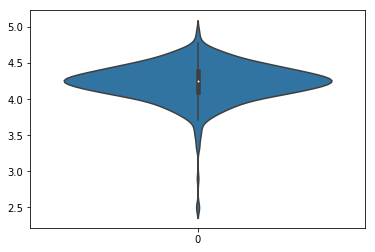

In [46]:
# lets keep it simple and just take the rating of the area by taking the mean
mean_rating = extract_rating.apply((lambda x: np.mean(x) if x else None))
# mean_rating.head()

ax = sns.violinplot(data=mean_rating.T)

## Let's get an idea of how our feature look depending of the position

In [47]:
def normalize(x):
    a = x - x.min()
    return (a/a.max())

In [48]:
dist = haversine_np(mean_lon, mean_lat, dlon, dlat) * 700

In [49]:
def plt_map(mean_lat, mean_lon, dist, feature):
    cm = branca.colormap.LinearColormap(['green', 'yellow', 'red'], vmin=0, vmax=1)
    n = normalize(feature)
    color = [cm(x) if not np.isnan(x) else None for x in n]

    m = folium.Map(
        location=[np.mean(mean_lat), np.mean(mean_lon)],
        zoom_start=8
    )

    for la, lo, d, c in zip(mean_lat, mean_lon, dist, color):
        if not np.isnan(la):
#             d = haversine_np(lo, la, dlo, dla)
            folium.features.Circle(
                radius=d,
                location=[la, lo],
                color=c,
                fill_color=c,
                fill_opacity=0.6,
                fill=True,
            ).add_to(m)

    return m

In [50]:
plt_map(mean_lat, mean_lon, dist, mean_rating)

In [51]:
plt_map(mean_lat, mean_lon, dist, extract_number_reviews.sum(1))

In [52]:
plt_map(mean_lat, mean_lon, dist, targets.total["total"])

In [53]:
plt_map(mean_lat, mean_lon, dist, targets.total_norm[0])

In [54]:
# plt_map(mean_lat, mean_lon, dist, number_ameneties['accounting'])

In [55]:
plt_map(mean_lat, mean_lon, (targets.total["total"]/targets.total["total"].max())*5000, np.array([1]*len(mean_lat)))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [56]:
plt_map(mean_lat, mean_lon, (targets.total_norm[0]/targets.total_norm[0].max())*5000, np.array([1]*len(mean_lat)))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Lots of things that we can guess from those maps:

- city dont make the most
- ratings are relevant only in city
- airport big plus near lausanne
-
-
-

## lets make a model

as we dont have so many data it might e necessary to do n cross validation

In [57]:
# feature = pd.concat({'latitude': mean_lat, 'longitude': mean_lon, 'rating': mean_rating, 'bow_types': bow_types, 'number_ameneties': number_ameneties})
# # feature = pd.concat([ feature, bow_types, number_ameneties])
# feature.columns

In [117]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, KFold
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.tree import DecisionTreeRegressor

In [59]:
parameters_xgboost = {
              'learning_rate': [0.001, 0.01, 0.1], #so called `eta` value
              'max_depth': [3, 6, 8],
              'subsample': [0.6, 0.7, 0.8],
              'colsample_bytree': [0.6, 0.7, 0.8],
              'n_estimators': [200], #number of trees, change it to 1000 for better results
              'seed': [1337]}

clf_xgboost = GridSearchCV(XGBRegressor(eval_metric='mae'), parameters_xgboost, n_jobs=2, 
                   cv=KFold(n_splits=5, shuffle=True),
#                    scoring='accuracy',
                   verbose=1,
                   refit=True)

In [60]:
X_train_id, X_test_id, y_train_id, y_test_id = train_test_split(
    range(len(bow_types)), range(len(bow_types)), test_size=0.20, random_state=42)

In [112]:
def train_printinfo(feature, target, clf=clf_xgboost):
    X_train = feature.iloc[X_train_id].as_matrix()
    y_train = target.iloc[y_train_id].as_matrix()
    X_test = feature.iloc[X_test_id].as_matrix()
    y_test = target.iloc[y_test_id].as_matrix()

    clf.fit(X_train, y_train)

    print('='*10)
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    
    y_pred = clf.best_estimator_.predict(X_test)
#     pre = y_pred * feature.std().as_matrix() + feature.mean().as_matrix()
#     tes = y_test * feature.std().as_matrix() + feature.mean().as_matrix()
#     f = f * f.std() + f.mean()
    print("mae", np.mean(np.abs(y_pred - y_test)))
          
    print("clf score", clf.score(X_test, y_test))
        
    plt.plot(y_pred)
    plt.plot(y_test)
    plt.show()

    try:
        importances = clf.best_estimator_.feature_importances_

        # plt.bar(range(len(bow_types.columns)), importances,
        #        color="r", align="center")
        imp = pd.Series(importances, index=feature.columns).sort_values()[::-1]
        imp.plot.bar()
        plt.show()

        print(imp[:20])
    except:
        pass
    
    return clf.best_estimator_

def train_nogrid(feature, target, clf=clf_xgboost):
    X_train = feature.iloc[X_train_id].as_matrix()
    y_train = target.iloc[y_train_id].as_matrix()
    X_test = feature.iloc[X_test_id].as_matrix()
    y_test = target.iloc[y_test_id].as_matrix()

    clf.fit(X_train, y_train)

    print('='*10)
    
    y_pred = clf.predict(X_test)
    print("mae", np.mean(np.abs(y_pred - y_test)))
          
    print("clf score", clf.score(X_test, y_test))
        
    plt.plot(y_pred)
    plt.plot(y_test)
    plt.show()

#     importances = clf.feature_importances_

#     imp = pd.Series(importances, index=feature.columns).sort_values()[::-1]
#     imp.plot.bar()
#     plt.show()
    
#     print(imp[:20])
    
    return clf

Lets see how the bow feature from types works

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   44.0s
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:  1.8min finished


Best estimator found by grid search:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='mae', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=True,
       subsample=0.8)
mae 25279.9409579
clf score 0.477343960477


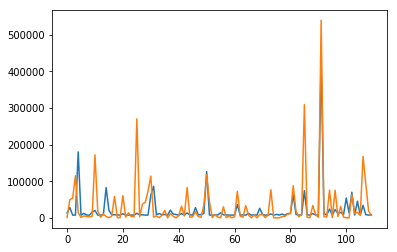

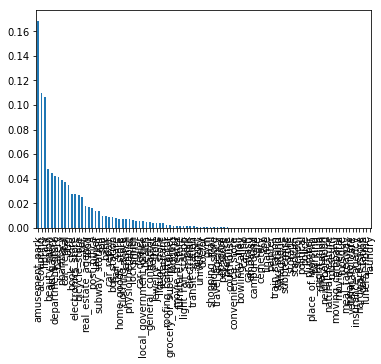

amusement_park        0.168637
accounting            0.109535
library               0.106383
beauty_salon          0.048069
art_gallery           0.044917
department_store      0.042553
bakery                0.040977
pharmacy              0.038613
car_rental            0.037037
atm                   0.034673
book_store            0.027581
electronics_store     0.027581
bicycle_store         0.026793
bar                   0.025217
real_estate_agency    0.018125
food                  0.016548
post_office           0.015760
lawyer                0.013396
subway_station        0.013396
spa                   0.009456
dtype: float32


In [62]:
clf_bow = train_printinfo(bow_types, targets.total["total"])

lets try by total norm

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   48.0s
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:  1.9min finished


Best estimator found by grid search:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, eval_metric='mae', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=True,
       subsample=0.6)
mae 45.479844783
clf score -0.181017761483


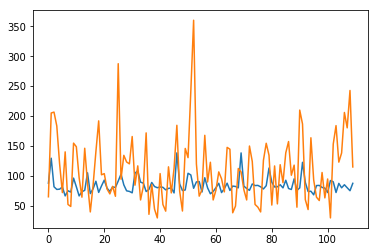

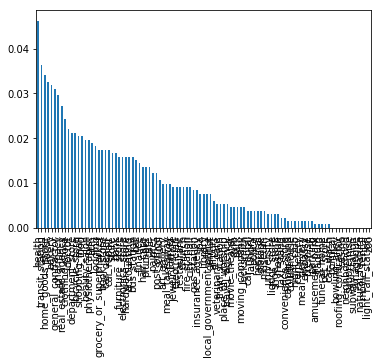

health                    0.046247
transit_station           0.036391
home_goods_store          0.034117
florist                   0.032600
bakery                    0.031842
general_contractor        0.031084
pharmacy                  0.029568
real_estate_agency        0.027293
clothing_store            0.024261
doctor                    0.021986
department_store          0.021228
bicycle_store             0.021228
shopping_mall             0.020470
food                      0.020470
beauty_salon              0.019712
physiotherapist           0.019712
atm                       0.018954
lodging                   0.018196
grocery_or_supermarket    0.017437
book_store                0.017437
dtype: float32


In [63]:
clf_bownorm = train_printinfo(bow_types, targets.total_norm[0])

mae 33350.4545455
clf score -0.227396191307


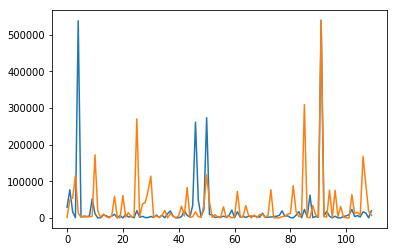

mae 63.3571145587
clf score -1.29706376985


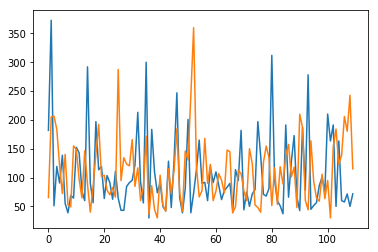

In [118]:
clf_bownorm = train_nogrid(bow_types, targets.total["total"], clf=DecisionTreeRegressor())
clf_bownorm = train_nogrid(bow_types, targets.total_norm[0], clf=DecisionTreeRegressor())

Lets see how the number of ameneties feature work

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.8s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   39.3s
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:  1.7min finished


Best estimator found by grid search:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, eval_metric='mae', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=True,
       subsample=0.7)
mae 26041.9271196
clf score 0.508615184689


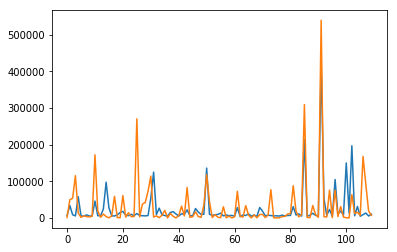

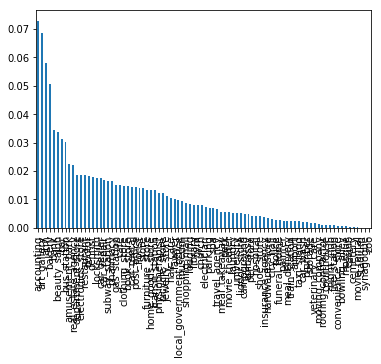

accounting            0.072905
art_gallery           0.068419
atm                   0.058164
bakery                0.050473
bank                  0.034450
beauty_salon          0.033809
bar                   0.031245
bus_station           0.030284
amusement_park        0.022593
real_estate_agency    0.022272
department_store      0.018747
electronics_store     0.018587
restaurant            0.018427
doctor                0.018106
dentist               0.017786
locksmith             0.017625
car_dealer            0.017465
car_repair            0.016984
subway_station        0.016504
pharmacy              0.016344
dtype: float32
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   41.3s
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:  1.7min finished


Best estimator found by grid search:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eval_metric='mae', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=True,
       subsample=0.7)
mae 45.5317221616
clf score -0.164997580876


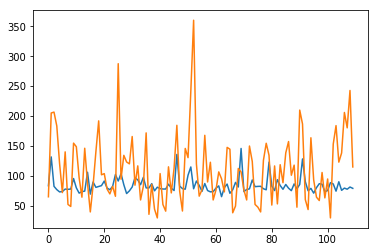

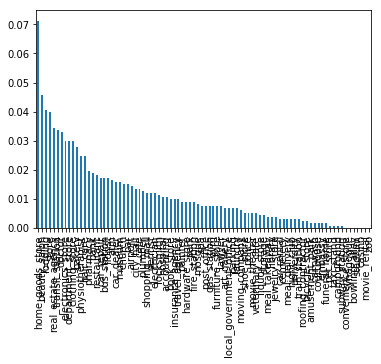

home_goods_store      0.071268
beauty_salon          0.045761
lodging               0.040510
store                 0.039760
real_estate_agency    0.034509
transit_station       0.033758
doctor                0.033008
electronics_store     0.030008
department_store      0.030008
clothing_store        0.030008
bakery                0.027757
physiotherapist       0.024756
hair_care             0.024756
pharmacy              0.019505
bank                  0.018755
restaurant            0.018005
car_repair            0.017254
bus_station           0.017254
florist               0.017254
atm                   0.016504
dtype: float32


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eval_metric='mae', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=True,
       subsample=0.7)

In [64]:
train_printinfo(number_ameneties, targets.total["total"])
train_printinfo(number_ameneties, targets.total_norm[0])

conclu

Now lets try position feature

In [65]:
feature_lat_lon = pd.concat({'latitude': mean_lat, 'longitude': mean_lon}, 1)
feature_lat_lon.head()

latitude  longitude
0  46.195629   6.193847
1  46.204399   6.200112
2  46.780945   6.636348
3  46.540162   6.621443
4  46.770865   6.650237

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Done 340 tasks      | elapsed:   10.3s
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:   12.5s finished


Best estimator found by grid search:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, eval_metric='mae', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=1337, silent=True, subsample=0.8)
mae 33062.4608964
clf score -0.489330803596


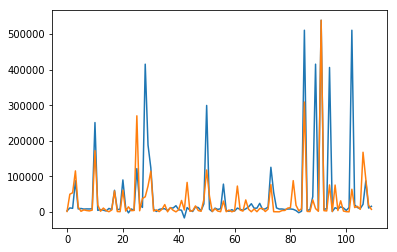

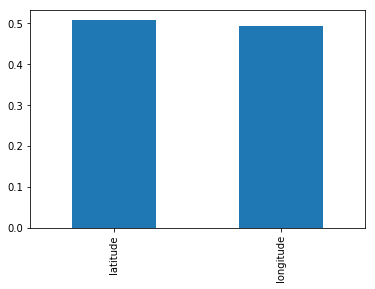

latitude     0.507101
longitude    0.492899
dtype: float32
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Done 256 tasks      | elapsed:    7.1s
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:   11.9s finished


Best estimator found by grid search:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, eval_metric='mae', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=True,
       subsample=0.8)
mae 42.0427388978
clf score -0.0736968366727


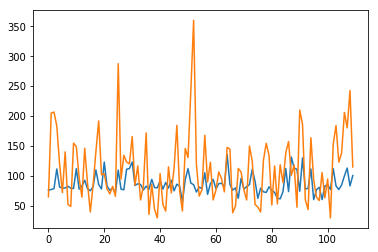

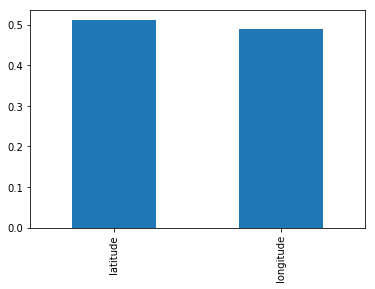

latitude     0.51087
longitude    0.48913
dtype: float32


In [66]:
clf_lat_lon_total = train_printinfo(feature_lat_lon, targets.total["total"])
clf_lat_lon_totalnorm = train_printinfo(feature_lat_lon, targets.total_norm[0])

In [67]:
min_lat.min()
max_lat.max()
min_lon.min()
max_lon.max()

x = np.linspace(min_lat.min(), max_lat.max(), 1000)
y = np.linspace(min_lon.min(), max_lon.max(), 1000)

xx, yy = np.meshgrid(x,y)

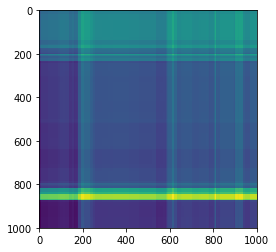

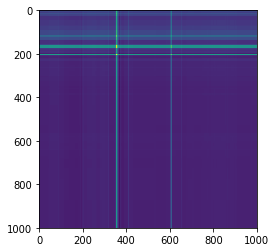

In [68]:
Z = clf_lat_lon_totalnorm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.imshow(Z)
plt.show()

Z = clf_lat_lon_total.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.imshow(Z)
plt.show()

cant really see, lets do something a bit smarter

In [69]:
ll = np.stack([mean_lat, mean_lon], 1)
dd = np.stack([dlat, dlon], 1) * 5
gen_point = lambda: np.random.normal(loc=ll, scale=dd)
sampled = np.concatenate([gen_point() for i in range(4)])
sampled = pd.DataFrame(sampled).dropna().as_matrix()

In [70]:
plt_map(sampled[:,0], sampled[:,1], [1]*len(sampled), clf_lat_lon_total.predict(sampled))

In [71]:
plt_map(sampled[:,0], sampled[:,1], [1]*len(sampled), clf_lat_lon_totalnorm.predict(sampled))

In [72]:
# lets use lat, lon and types
feature_bow_lat_lon = pd.concat([bow_types, feature_lat_lon], 1)
feature_bow_lat_lon.head()

accounting  airport  amusement_park  art_gallery  atm  bakery  bank  bar  \
0           3        0               0            1    2       8     4    2   
1           0        0               0            0    0       2     0    0   
2           2        0               0            0    4       8     2    6   
3           0        0               0            0    0       0     0    3   
4           0        0               0            0    0       0     0    0   

   beauty_salon  bicycle_store    ...      synagogue  taxi_stand  \
0             6              2    ...              0           0   
1             0              0    ...              0           0   
2             7              2    ...              0           0   
3             4              0    ...              0           0   
4             0              0    ...              0           0   

   train_station  transit_station  travel_agency  university  veterinary_care  \
0              0                4              1           0                1   
1              0                2              0           0                0   
2              0                8              2           0                0   
3              0                2              0           0                0   
4              0                8              0           0                0   

   zoo   latitude  longitude  
0    0  46.195629   6.193847  
1    0  46.204399   6.200112  
2    0  46.780945   6.636348  
3    0  46.540162   6.621443  
4    0  46.770865   6.650237  

[5 rows x 101 columns]

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   11.9s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   56.5s
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:  2.1min finished


Best estimator found by grid search:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='mae', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=True,
       subsample=0.7)
mae 18650.2308816
clf score 0.74573976878


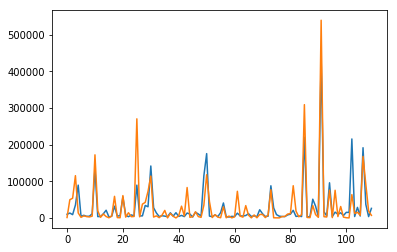

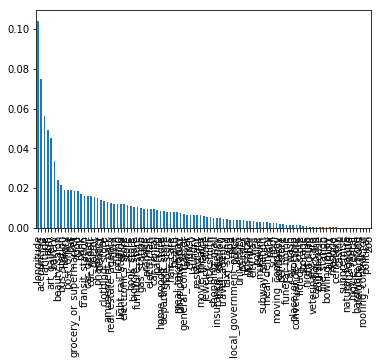

longitude                 0.104219
accounting                0.074770
latitude                  0.056182
atm                       0.049290
art_gallery               0.045322
bakery                    0.033626
beauty_salon              0.023810
bus_station               0.021512
library                   0.019215
post_office               0.019006
bar                       0.018797
grocery_or_supermarket    0.018379
food                      0.018379
bank                      0.017126
transit_station           0.015873
car_dealer                0.015873
car_repair                0.015873
doctor                    0.015664
pharmacy                  0.014829
dentist                   0.014202
dtype: float32
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   46.3s
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:  1.8min finished


Best estimator found by grid search:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, eval_metric='mae', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=1337, silent=True, subsample=0.7)
mae 42.8944750734
clf score -0.0372962619703


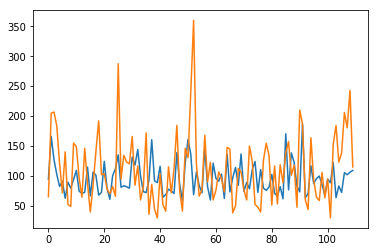

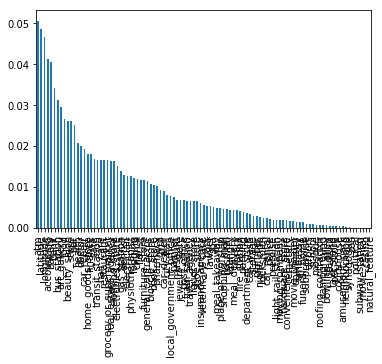

atm                 0.050663
latitude            0.048755
longitude           0.046751
accounting          0.041313
bakery              0.040550
bank                0.034157
bus_station         0.031199
art_gallery         0.029482
food                0.026715
beauty_salon        0.026143
store               0.026143
bar                 0.025188
health              0.020704
doctor              0.020132
car_repair          0.019368
home_goods_store    0.018033
finance             0.018033
cafe                0.016792
transit_station     0.016601
hair_care           0.016601
dtype: float32


In [73]:
clf_best = train_printinfo(feature_bow_lat_lon, targets.total["total"])
clf_bestnorm = train_printinfo(feature_bow_lat_lon, targets.total_norm[0])

In [74]:
feature_bow_lat_lon_rating = pd.concat([feature_bow_lat_lon, mean_rating], 1)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   11.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   49.5s
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:  2.0min finished


Best estimator found by grid search:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eval_metric='mae', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=1337, silent=True, subsample=0.7)
mae 23183.1049608
clf score 0.613165720484


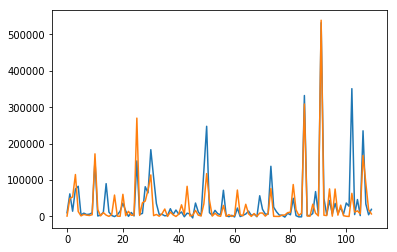

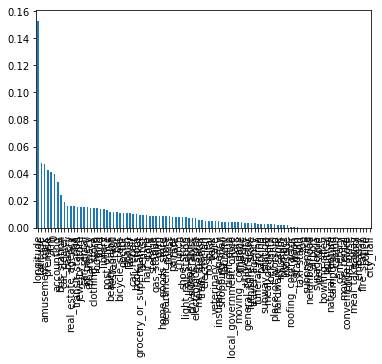

longitude             0.153052
latitude              0.048151
amusement_park        0.047291
premise               0.042992
atm                   0.041273
0                     0.039553
accounting            0.033534
bus_station           0.024076
car_dealer            0.018917
bakery                0.016337
real_estate_agency    0.016337
spa                   0.016337
transit_station       0.015477
jewelry_store         0.015477
car_rental            0.015477
art_gallery           0.015477
pharmacy              0.014617
clothing_store        0.014617
lodging               0.014617
food                  0.013758
dtype: float32
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   55.2s
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:  2.2min finished


Best estimator found by grid search:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, eval_metric='mae', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=1337, silent=True, subsample=0.7)
mae 43.2948565309
clf score -0.0360793978537


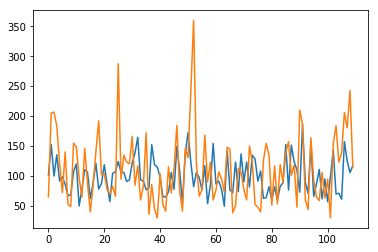

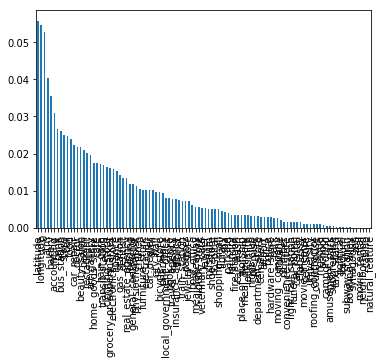

latitude            0.055799
longitude           0.054519
0                   0.052872
atm                 0.040432
bakery              0.035492
accounting          0.030918
bank                0.026528
bus_station         0.025979
store               0.025064
bar                 0.024698
food                0.023966
car_repair          0.022320
doctor              0.021771
beauty_salon        0.021771
health              0.021039
restaurant          0.020124
art_gallery         0.019576
home_goods_store    0.017563
cafe                0.017380
hair_care           0.017197
dtype: float32


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, eval_metric='mae', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=1337, silent=True, subsample=0.7)

In [75]:
train_printinfo(feature_bow_lat_lon_rating, targets.total["total"])
train_printinfo(feature_bow_lat_lon_rating, targets.total_norm[0])

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Done 256 tasks      | elapsed:    6.3s
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:   10.2s finished


Best estimator found by grid search:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, eval_metric='mae', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=True,
       subsample=0.8)
mae 29686.4492276
clf score 0.27267370864


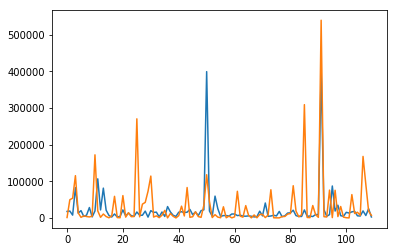

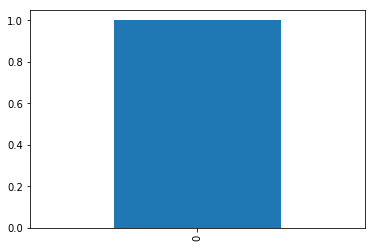

0    1.0
dtype: float32
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:    9.4s finished


Best estimator found by grid search:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, eval_metric='mae', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=True,
       subsample=0.7)
mae 46.2313591783
clf score -0.214438933789


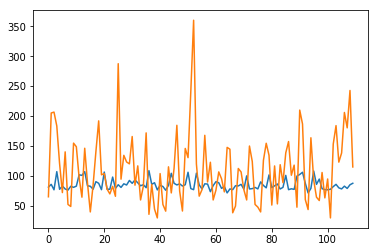

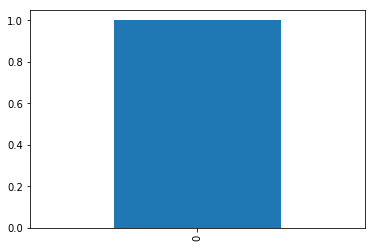

0    1.0
dtype: float32


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, eval_metric='mae', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=True,
       subsample=0.7)

In [116]:
train_printinfo(pd.DataFrame(mean_rating), targets.total["total"])
train_printinfo(pd.DataFrame(mean_rating), targets.total_norm[0])
# mean_rating

we can see improvment

In [76]:
from sklearn import svm
# from sklearn.ensemble import RandomForestRegressor

tuned_parameters = [
                    {'kernel': ['rbf'], 'gamma': [14, 10, 8],
                     'C': [150, 200, 250]},
                    {'kernel': ['linear'], 'C': [5, 7, 10]}
                   ]
clf_svm = GridSearchCV(svm.SVR(), tuned_parameters, n_jobs=2, 
                   cv=KFold(n_splits=5, shuffle=True),
#                    scoring='accuracy',
                   verbose=1,
                   refit=True)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:  1.4min finished


Best estimator found by grid search:
SVR(C=150, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=8,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
mae 0.37923426789
clf score 0.488774683801


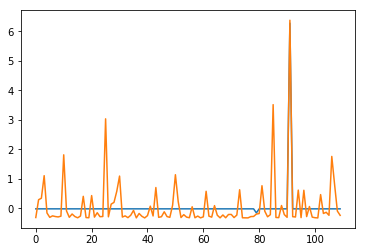

SVR(C=150, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=8,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [77]:
# this kind of model need to normalize the input to be able to train fast
# f = feature_bow_lat_lon.fillna(0)
# f = f - f.min()
# f = f / f.max()
# train_printinfo(f, targets.total_norm[1], clf=clf_svm)
feature_bow_lat_lon.longitude = feature_bow_lat_lon.longitude.fillna(feature_bow_lat_lon.longitude.mean())
feature_bow_lat_lon.latitude = feature_bow_lat_lon.latitude.fillna(feature_bow_lat_lon.latitude.mean())
f = feature_bow_lat_lon
f = f - f.mean()
f = f / f.std()
t = targets.total["total"]
t = t - t.mean()
t = t / t.std()
t_norm = targets.total_norm[0]
t_norm = t_norm - t_norm.mean()
t_norm = t_norm / t_norm.std()
train_printinfo(f, t, clf=clf_svm)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   50.2s finished


Best estimator found by grid search:
SVR(C=150, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=8,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
mae 0.751884156695
clf score -0.023931991765


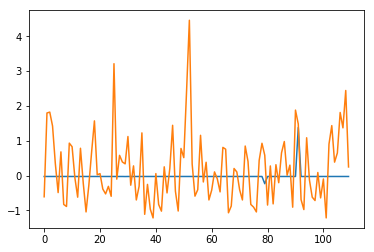

SVR(C=150, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=8,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [78]:
train_printinfo(f, t_norm, clf=clf_svm)

not very promising with svm
lets see what nn can do

In [79]:
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras import regularizers

Using TensorFlow backend.
/usr/local/Cellar/python/3.6.4_3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [80]:
def base():
    model = Sequential()
    model.add(Dense(60, input_dim=f.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(60, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(60, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

estimator = KerasRegressor(build_fn=base, nb_epoch=100, batch_size=15, verbose=0)

mae 0.31595812094
clf score 0.385371231559


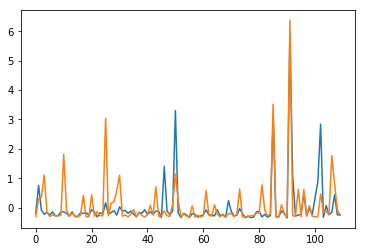

mae 0.84692829158
clf score 1.2862833061


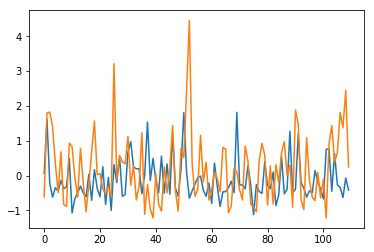

In [103]:
train_nogrid(f, t, clf=estimator)
train_nogrid(f, t_norm, clf=estimator)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.9s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   37.0s
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:  1.7min finished


Best estimator found by grid search:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, eval_metric='mae', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=True,
       subsample=0.8)
mae 0.282635592897
clf score 0.731657794975


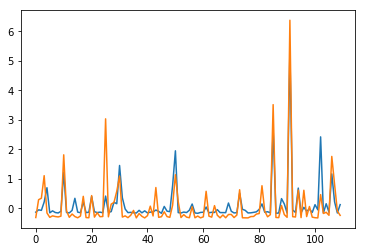

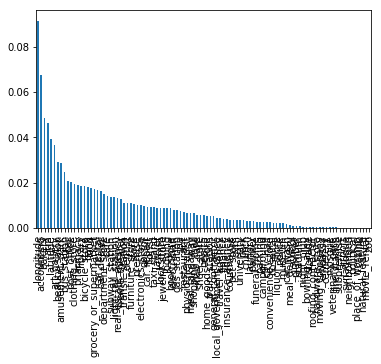

longitude                 0.091516
accounting                0.067594
bakery                    0.048401
atm                       0.046453
latitude                  0.039221
art_gallery               0.036718
beauty_salon              0.029207
amusement_park            0.028651
bus_station               0.024757
bar                       0.020862
post_office               0.020028
clothing_store            0.019193
pharmacy                  0.018915
library                   0.018637
bicycle_store             0.018637
bank                      0.018081
food                      0.017524
grocery_or_supermarket    0.016968
car_rental                0.016690
car_dealer                0.016412
dtype: float32
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   44.4s
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:  1.8min finished


Best estimator found by grid search:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='mae', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=True,
       subsample=0.8)
mae 0.684500435501
clf score 0.116250024994


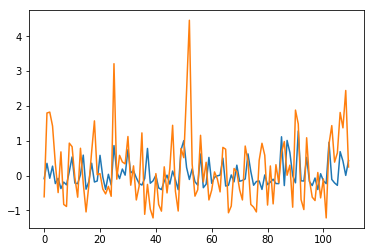

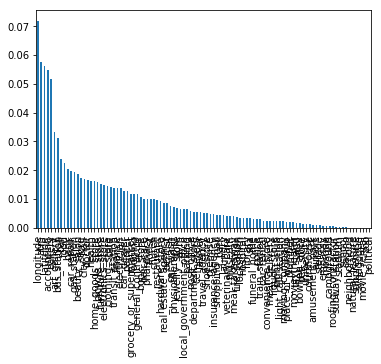

longitude           0.071944
atm                 0.057618
latitude            0.056258
accounting          0.054795
bakery              0.051553
art_gallery         0.033253
bus_station         0.031162
bar                 0.023737
food                0.022482
bank                0.020496
car_repair          0.019659
gas_station         0.019241
beauty_salon        0.018823
store               0.017359
city_hall           0.016836
doctor              0.016522
health              0.016208
home_goods_store    0.016208
bicycle_store       0.015999
furniture_store     0.015058
dtype: float32


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='mae', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=True,
       subsample=0.8)

In [113]:
train_printinfo(f, t)
train_printinfo(f, t_norm)

simple NN do much better, but not as well as xgboost

In [83]:
X_train = f.iloc[X_train_id].as_matrix()
y_train = t_norm.iloc[y_train_id].as_matrix()
X_test = f.iloc[X_test_id].as_matrix()
y_test = t_norm.iloc[y_test_id].as_matrix()

model = base()
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=10, epochs=100, verbose=0)

0.931694687544


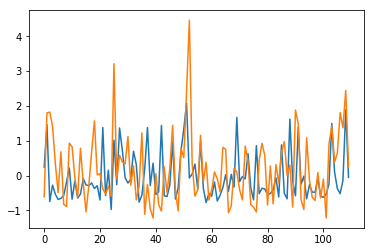

In [84]:
print(np.mean(np.abs(model.predict(X_test) - y_test)))

plt.plot(model.predict(X_test))
plt.plot(y_test)

As it is in most case with small dataset boosting algo perform way better, lets stop here for testing models

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:  2.2min finished


Best estimator found by grid search:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='mae', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=True,
       subsample=0.6)
mae 40.7637692168
clf score -0.000374506675372


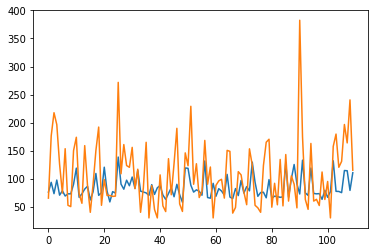

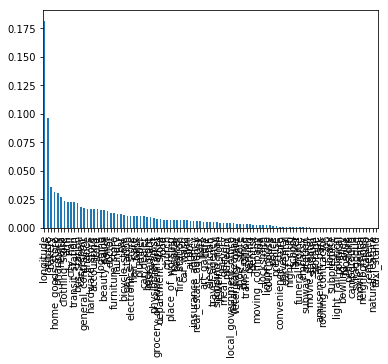

longitude             0.181748
latitude              0.096626
bakery                0.036043
home_goods_store      0.031442
pharmacy              0.030675
health                0.026840
clothing_store        0.023773
atm                   0.023006
city_hall             0.023006
transit_station       0.022239
bus_station           0.021472
car_repair            0.018405
general_contractor    0.017638
finance               0.016871
hardware_store        0.016871
accounting            0.016871
store                 0.016104
lodging               0.015337
beauty_salon          0.015337
florist               0.014571
dtype: float32


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='mae', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=True,
       subsample=0.6)

In [85]:
train_printinfo(feature_bow_lat_lon, targets.total_year_norm[2017])

cluster area

In [86]:
# from sklearn.cluster import KMeans, DBSCAN
# from sklearn import mixture

In [87]:
# db = DBSCAN(eps=0.04, min_samples=4)
# db = KMeans(n_clusters=25)
# db = mixture.GaussianMixture(n_components=40)

In [88]:
# c = db.fit(np.stack([mean_lat.dropna(), mean_lon.dropna()], 1))
# pred = c.predict(np.stack([mean_lat.dropna(), mean_lon.dropna()], 1))
# pred = c.labels_

In [89]:
# plt.scatter(mean_lat.dropna(), mean_lon.dropna(), c=pred)

In [90]:
# plt_map(mean_lat.dropna(), mean_lon.dropna(), [0.001]*len(pred), [0.001]*len(pred), pred)

lets see what in our best model permit to improve the sales

In [91]:
d = pd.DataFrame()
for i, key in enumerate(bow_types.columns):
#     print(key)
    feature = bow_types[key]
    x = np.linspace(feature.min(), feature.max(), 10)
    x_to = np.zeros([10, bow_types.shape[1]])
    x_to[:, i] = x
    d[key] = clf_bow.predict(x_to)
#     plt.plot(clf_bow.predict(x_to))
#     plt.show()
# d.iloc[0].max()

assert np.all(d.max().index == bow_types.columns)
pd.DataFrame({"importance": clf_bow.feature_importances_, "output": d.max()}).sort_values('importance')[::-1]

importance         output
amusement_park        0.168637  234265.484375
accounting            0.109535    7788.083984
library               0.106383   89542.468750
beauty_salon          0.048069    8374.173828
art_gallery           0.044917    7788.083984
department_store      0.042553   56519.187500
bakery                0.040977   13066.039062
pharmacy              0.038613   49563.023438
car_rental            0.037037   41061.699219
atm                   0.034673    7788.083984
book_store            0.027581    7788.083984
electronics_store     0.027581    7788.083984
bicycle_store         0.026793   25481.853516
bar                   0.025217   12650.605469
real_estate_agency    0.018125   35531.277344
food                  0.016548   13080.827148
post_office           0.015760   23085.189453
lawyer                0.013396   20647.433594
subway_station        0.013396   27597.458984
spa                   0.009456   14854.985352
bank                  0.009456    7788.083984
car_repair            0.008668    7788.083984
bus_station           0.008668   19167.158203
hair_care             0.007880    7788.083984
home_goods_store      0.007092    7788.083984
clothing_store        0.007092    7788.083984
church                0.007092    7788.083984
physiotherapist       0.007092   18387.250000
locksmith             0.006304    9444.443359
florist               0.005516    7788.083984
...                        ...            ...
painter               0.000000    7788.083984
train_station         0.000000    7788.083984
taxi_stand            0.000000    7788.083984
synagogue             0.000000    7788.083984
subpremise            0.000000    7788.083984
store                 0.000000    7788.083984
storage               0.000000    7788.083984
stadium               0.000000    7788.083984
school                0.000000    7788.083984
political             0.000000    7788.083984
police                0.000000    7788.083984
plumber               0.000000    7788.083984
place_of_worship      0.000000    7788.083984
parking               0.000000    7788.083984
night_club            0.000000    7788.083984
fire_station          0.000000    7788.083984
neighborhood          0.000000    7788.083984
natural_feature       0.000000    7788.083984
museum                0.000000    7788.083984
moving_company        0.000000    7788.083984
movie_rental          0.000000    7788.083984
mosque                0.000000    7788.083984
meal_takeaway         0.000000    7788.083984
meal_delivery         0.000000    7788.083984
veterinary_care       0.000000    7788.083984
insurance_agency      0.000000    7788.083984
hardware_store        0.000000    7788.083984
gas_station           0.000000    7788.083984
funeral_home          0.000000    7788.083984
laundry               0.000000    7788.083984

[99 rows x 2 columns]

In [92]:
d = pd.DataFrame()
for i, key in enumerate(bow_types.columns):
#     print(key)
    feature = bow_types[key]
    x = np.linspace(feature.min(), feature.max(), 10)
    x_to = np.zeros([10, bow_types.shape[1]])
    x_to[:, i] = x
    d[key] = clf_bownorm.predict(x_to)
#     plt.show()

assert np.all(d.max().index == bow_types.columns)
pd.DataFrame({"importance": clf_bownorm.feature_importances_, "output": d.max()}).sort_values('importance')[::-1]

importance     output
health                    0.046247  79.397804
transit_station           0.036391  75.063629
home_goods_store          0.034117  85.851677
florist                   0.032600  77.597099
bakery                    0.031842  80.904961
general_contractor        0.031084  75.237030
pharmacy                  0.029568  86.444534
real_estate_agency        0.027293  78.183029
clothing_store            0.024261  82.582855
doctor                    0.021986  75.183327
department_store          0.021228  91.136368
bicycle_store             0.021228  81.154228
shopping_mall             0.020470  84.493614
food                      0.020470  74.954803
beauty_salon              0.019712  74.446190
physiotherapist           0.019712  74.446190
atm                       0.018954  74.446190
lodging                   0.018196  74.730309
grocery_or_supermarket    0.017437  77.092003
book_store                0.017437  75.384315
car_dealer                0.017437  78.154617
car_repair                0.017437  74.446190
store                     0.016679  77.156609
bank                      0.016679  74.623779
furniture_store           0.015921  77.748337
electronics_store         0.015921  74.446190
hardware_store            0.015921  75.060417
accounting                0.015921  74.513985
bus_station               0.015921  75.153427
bar                       0.015163  74.446190
...                            ...        ...
liquor_store              0.003033  74.480515
shoe_store                0.003033  74.446190
mosque                    0.003033  74.446190
taxi_stand                0.002274  74.985748
convenience_store         0.002274  74.446190
campground                0.001516  75.545456
courthouse                0.001516  74.446190
night_club                0.001516  75.215584
cemetery                  0.001516  74.446190
meal_delivery             0.001516  74.893585
embassy                   0.001516  74.446190
premise                   0.001516  74.879219
parking                   0.001516  74.782860
amusement_park            0.000758  74.446190
stadium                   0.000758  74.446190
funeral_home              0.000758  74.446190
pet_store                 0.000758  74.446190
car_wash                  0.000758  74.446190
political                 0.000000  74.446190
bowling_alley             0.000000  74.446190
roofing_contractor        0.000000  74.446190
casino                    0.000000  74.446190
neighborhood              0.000000  74.446190
subpremise                0.000000  74.446190
subway_station            0.000000  74.446190
synagogue                 0.000000  74.446190
natural_feature           0.000000  74.446190
movie_rental              0.000000  74.446190
light_rail_station        0.000000  74.446190
zoo                       0.000000  74.446190

[99 rows x 2 columns]

In [93]:
d = pd.DataFrame()
for i, key in enumerate(feature_bow_lat_lon.columns):
#     print(key)
    feature = feature_bow_lat_lon[key]
    x = np.linspace(feature.min(), feature.max(), 10)
    x_to = np.zeros([10, feature_bow_lat_lon.shape[1]])
    x_to[:, i] = x
    d[key] = clf_best.predict(x_to)
#     plt.plot(clf_bow.predict(x_to))
#     plt.show()
# d.iloc[0].max()

assert np.all(d.max().index == feature_bow_lat_lon.columns)
pd.DataFrame({"importance": clf_best.feature_importances_, "output": d.max()}).sort_values('importance')[::-1]

importance        output
longitude                 0.104219  18819.894531
accounting                0.074770  23630.789062
latitude                  0.056182  95908.125000
atm                       0.049290  18546.152344
art_gallery               0.045322  17231.835938
bakery                    0.033626  21300.285156
beauty_salon              0.023810  18265.847656
bus_station               0.021512  24179.832031
library                   0.019215  81800.484375
post_office               0.019006  27742.554688
bar                       0.018797  17498.160156
grocery_or_supermarket    0.018379  28653.240234
food                      0.018379  18431.437500
bank                      0.017126  17151.710938
transit_station           0.015873  26875.195312
car_dealer                0.015873  21735.425781
car_repair                0.015873  18240.828125
doctor                    0.015664  17002.203125
pharmacy                  0.014829  46786.656250
dentist                   0.014202  17410.441406
clothing_store            0.013576  22565.445312
amusement_park            0.012949  72288.156250
real_estate_agency        0.012531  19587.533203
gym                       0.012114  24042.847656
lodging                   0.012114  19686.240234
light_rail_station        0.012114  17160.521484
electronics_store         0.011905  18347.062500
store                     0.011696  17565.351562
book_store                0.011069  17723.515625
bicycle_store             0.010652  46607.699219
...                            ...           ...
school                    0.002297  17002.203125
moving_company            0.002297  17002.203125
embassy                   0.002089  17596.355469
pet_store                 0.001671  18126.703125
funeral_home              0.001462  17535.058594
car_wash                  0.001462  17002.203125
place_of_worship          0.001462  18518.332031
convenience_store         0.001462  17002.203125
liquor_store              0.001253  17002.203125
storage                   0.001044  17002.203125
night_club                0.001044  17002.203125
stadium                   0.000627  17002.203125
veterinary_care           0.000627  17002.203125
campground                0.000627  17274.984375
courthouse                0.000418  17002.203125
fire_station              0.000418  17002.203125
bowling_alley             0.000418  17002.203125
airport                   0.000209  17002.203125
mosque                    0.000209  17002.203125
cemetery                  0.000209  17002.203125
casino                    0.000000  17002.203125
subpremise                0.000000  17002.203125
natural_feature           0.000000  17002.203125
synagogue                 0.000000  17002.203125
movie_rental              0.000000  17002.203125
hardware_store            0.000000  17002.203125
neighborhood              0.000000  17002.203125
roofing_contractor        0.000000  17002.203125
political                 0.000000  17002.203125
zoo                       0.000000  17002.203125

[101 rows x 2 columns]

In [94]:
d = pd.DataFrame()
for i, key in enumerate(feature_bow_lat_lon.columns):
#     print(key)
    feature = feature_bow_lat_lon[key]
    x = np.linspace(feature.min(), feature.max(), 10)
    x_to = np.zeros([10, feature_bow_lat_lon.shape[1]])
    x_to[:, i] = x
    d[key] = clf_bestnorm.predict(x_to)
#     plt.plot(clf_bow.predict(x_to))
#     plt.show()
# d.iloc[0].max()

assert np.all(d.max().index == feature_bow_lat_lon.columns)
pd.DataFrame({"importance": clf_bestnorm.feature_importances_, "output": d.max()}).sort_values('importance')[::-1]

importance      output
atm                       0.050663   90.489578
latitude                  0.048755  136.078583
longitude                 0.046751   90.676270
accounting                0.041313   92.150848
bakery                    0.040550   90.489578
bank                      0.034157   93.335716
bus_station               0.031199   90.489578
art_gallery               0.029482   90.489578
food                      0.026715   95.797325
beauty_salon              0.026143   90.489578
store                     0.026143  106.923622
bar                       0.025188   90.489578
health                    0.020704   90.489578
doctor                    0.020132   90.489578
car_repair                0.019368   90.489578
home_goods_store          0.018033  103.401360
finance                   0.018033   98.173843
cafe                      0.016792   93.179260
transit_station           0.016601   94.781036
hair_care                 0.016601   96.794746
restaurant                0.016601   95.334251
grocery_or_supermarket    0.016506   91.866203
real_estate_agency        0.016411   97.483620
clothing_store            0.016315   93.675529
electronics_store         0.015075   91.942924
gas_station               0.013930   93.888199
dentist                   0.012976   96.522240
electrician               0.012785   90.489578
physiotherapist           0.012594   93.365211
lodging                   0.012213   93.220627
...                            ...         ...
premise                   0.002004   90.489578
light_rail_station        0.001908   90.489578
moving_company            0.001908   90.489578
hardware_store            0.001908   90.489578
convenience_store         0.001908   90.489578
cemetery                  0.001717   90.489578
movie_theater             0.001622   90.489578
university                0.001336   90.489578
embassy                   0.001336   90.489578
funeral_home              0.001336   90.583946
subpremise                0.001050   90.591362
airport                   0.000954   90.489578
school                    0.000859   90.489578
mosque                    0.000763   90.489578
roofing_contractor        0.000572   90.489578
campground                0.000572   90.489578
bowling_alley             0.000572   90.489578
stadium                   0.000477   90.489578
taxi_stand                0.000477   90.489578
pet_store                 0.000477   90.753220
courthouse                0.000477   93.850693
amusement_park            0.000382   90.489578
neighborhood              0.000095   90.489578
synagogue                 0.000095   90.489578
zoo                       0.000000   90.489578
political                 0.000000   90.489578
subway_station            0.000000   90.489578
movie_rental              0.000000   90.489578
casino                    0.000000   90.489578
natural_feature           0.000000   90.489578

[101 rows x 2 columns]